In [1]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm
import torch
import torch.nn as nn

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, MiniBatchSparsePCA
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings('ignore')

from collections import Counter

cwd = os.getcwd()
cwd

'/Users/soob/Desktop/coding test'

In [2]:
data_dir = os.path.join(cwd, 'UX선행기획팀')

output = pd.read_csv(os.path.join(data_dir, 'output_sample.csv'))
output

,A게임 유저ID,B게임 플레이시 한달간 누적 플레이 예측 시간(분),B게임 플레이시 열성적인 플레이어가 될 확률,C게임 플레이시 한달간 누적 플레이 예측 시간(분),C게임 플레이시 열성적인 플레이어가 될 확률


# Read datasets

In [3]:
## Read data item description
did = pd.read_excel(os.path.join(data_dir, '과제 데이터 명세.xlsx'), engine='openpyxl') 
#did = pd.read_excel('C:\\Users\\LSB\\Desktop\\넥토리얼_분석가과제\\UX선행기획팀\\과제 데이터 명세.xlsx', engine='openpyxl') 

did_map ={}
for i in range(len(did)):
    did_map[did.loc[i,'컬럼명']] = did.loc[i,'컬럼설명']

## Read game datasets
game_A = pd.read_csv(os.path.join(data_dir, 'game_A.csv'))
game_B = pd.read_csv(os.path.join(data_dir, 'game_B.csv'))
game_C = pd.read_csv(os.path.join(data_dir, 'game_C.csv'))

print("data size")
print('game_A', game_A.shape)
print('game_B', game_B.shape)
print('game_C', game_C.shape)


## Create id list
user_A = set(game_A['id'])
user_B = set(game_B['id'])
user_C = set(game_C['id'])

user_AnB = set(game_A['id']) & set(game_B['id'])
user_AnC = set(game_A['id']) & set(game_C['id'])

print("No. of game A user:", len(user_A))
print("No. of game B user:", len(user_B))
print("No. of game C user:", len(user_C))
print("\nNo. of game A and B user:", len(user_AnB))
print("No. of game A and C user:", len(user_AnC))

data size
game_A (1570454, 16)
game_B (160677, 16)
game_C (409155, 11)
No. of game A user: 113408
No. of game B user: 14863
No. of game C user: 86183

No. of game A and B user: 921
No. of game A and C user: 8957


# Create New Data

In [8]:
# Convert 'sdate' feature to datetime type.
game_A['sdate'] = pd.to_datetime(game_A['sdate'])
game_B['sdate'] = pd.to_datetime(game_B['sdate'])
game_C['sdate'] = pd.to_datetime(game_C['sdate'])

game_A = game_A.sort_values(by='sdate', ascending=True)
game_B = game_B.sort_values(by='sdate', ascending=True)
game_C = game_C.sort_values(by='sdate', ascending=True)

features = ['on_count']
for col in game_A.columns:
    if (col != 'sdate') & (col != 'id'):
        features.append(str("cum_"+col))
        
features.append('weekday_cum_playtime')
features.append('weekend_cum_playtime')
features.append('total_cum_playtime_B')
features.append('total_cum_playtime_C')

df_A = pd.DataFrame(np.nan, index=user_A, columns=features)

# Compute weekdays & week-end average play time(apt) in game A
# Compute  cumulative play time(cpt) and average play time(apt) in game A
weekday = game_A.loc[game_A['sdate'].dt.weekday < 5]
weekend = game_A.loc[game_A['sdate'].dt.weekday >= 5]
wd_apt = pd.DataFrame(weekday['totalplaytime'].groupby(weekday['id']).sum())
we_apt = pd.DataFrame(weekend['totalplaytime'].groupby(weekend['id']).sum())
weekday_users = list(set(weekday['id']))
weekend_users = list(set(weekend['id']))

for _id in tqdm(weekday_users):
    df_A.loc[_id, 'weekday_cum_playtime'] = wd_apt.loc[_id][0]
    
for _id in tqdm(weekend_users):
    df_A.loc[_id, 'weekend_cum_playtime'] = we_apt.loc[_id][0]
    
for col in game_A:
    if col == 'id':
        pass
    elif col == 'sdate':
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).count())
        print('on_count')
        for _id in tqdm(user_A):
            df_A.loc[_id, 'on_count'] = D.loc[_id][0]
    else:
        feat = str('cum_'+col)
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).sum())
        print(feat)
        for _id in tqdm(user_A):
            if pd.isna(D.loc[_id,:])[0] == True:
                df_A.loc[_id, feat] = 0.0
            else:
                df_A.loc[_id, feat] = D.loc[_id][0]

game_B_cumPlaytime = pd.DataFrame(game_B['totalplaytime'].groupby(game_B['id']).sum())
for _id in tqdm(user_AnB):
    df_A.loc[_id, 'total_cum_playtime_B'] = game_B_cumPlaytime.loc[_id][0]
    
game_C_cumPlaytime = pd.DataFrame(game_C['totalplaytime'].groupby(game_C['id']).sum())
for _id in tqdm(user_AnC):
    df_A.loc[_id, 'total_cum_playtime_C'] = game_C_cumPlaytime.loc[_id][0]

allday_player = set(df_A[df_A['on_count'] >= 31.0].index)
for _id in tqdm(user_A):
    if _id in allday_player:
        df_A.loc[_id, 'is_allday_player'] = 1.0
    else:
        df_A.loc[_id, 'is_allday_player'] = 0.0

  1%|          | 732/113408 [00:00<00:38, 2927.45it/s]

on_count


  0%|          | 123/113408 [00:00<01:32, 1228.91it/s]

cum_totalplaytime


  0%|          | 124/113408 [00:00<01:31, 1233.38it/s]

cum_char_count


  0%|          | 398/113408 [00:00<01:12, 1558.88it/s]

cum_max_level


  0%|          | 396/113408 [00:00<01:11, 1591.60it/s]

cum_chat_count


  0%|          | 386/113408 [00:00<01:30, 1250.97it/s]

cum_itemget_count


  0%|          | 419/113408 [00:00<01:13, 1545.47it/s]

cum_itemuse_count


  0%|          | 89/113408 [00:00<02:07, 886.69it/s]

cum_gamemoneyuse_count


  0%|          | 391/113408 [00:00<01:16, 1484.07it/s]

cum_dead_count


  0%|          | 80/113408 [00:00<02:22, 797.91it/s]

cum_quest_count


  0%|          | 77/113408 [00:00<02:31, 747.63it/s]

cum_look_count


  0%|          | 404/113408 [00:00<01:13, 1547.62it/s]

cum_npc_count


  0%|          | 20/113408 [00:00<09:40, 195.28it/s]

cum_party_count


  0%|          | 400/113408 [00:00<01:14, 1523.23it/s]

cum_bosskill_count


  0%|          | 72/113408 [00:00<03:11, 592.61it/s]

cum_mail_count


100%|██████████| 113408/113408 [00:09<00:00, 11513.15it/s]


In [11]:
# Add day averaged value
for col in df_A.columns:
    if col.startswith('cum_'):
        df_A[str("avg_"+col[4:])] = df_A[col]/df_A['on_count']
        
df_A['weekday_day_playtime'] = df_A['weekday_cum_playtime']/df_A['on_count']
df_A['weekend_day_playtime'] = df_A['weekend_cum_playtime']/df_A['on_count']

In [203]:
if ('passionate_B' in df_A.columns) or ('passionate_C' in df_A.columns):
    df_A = df_A.drop(['passionate_B', 'passionate_C'], axis=1)
    
#B_users = df_A[df_A['total_cum_playtime_B'] > 0.0].copy()
#C_users = df_A[df_A['total_cum_playtime_C'] > 0.0].copy()

# Cumulative Play time top 75% user id list
#likeB_id = df_A[df_A['total_cum_playtime_B'] >= B_users['total_cum_playtime_B'].quantile(.75)].index
#likeC_id = df_A[df_A['total_cum_playtime_C'] >= C_users['total_cum_playtime_C'].quantile(.75)].index

likeB_id = df_A[df_A['total_cum_playtime_B'] >= df_A.loc[user_AnB, 'total_cum_playtime_B'].quantile(.75)].index
likeC_id = df_A[df_A['total_cum_playtime_C'] >= df_A.loc[user_AnC, 'total_cum_playtime_C'].quantile(.75)].index

# Assign label 1 to Cumulative Play time top 10% users, else 0.
df_A.loc[likeB_id, 'passionate_B'] = 1
df_A.loc[likeC_id, 'passionate_C'] = 1

In [206]:
A = df_A.replace(np.nan, 0)
A.describe()

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,avg_quest_count,avg_look_count,avg_npc_count,avg_party_count,avg_bosskill_count,avg_mail_count,weekday_day_playtime,weekend_day_playtime,passionate_B,passionate_C
count,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,1.134080e+05,113408.000000,113408.000000,113408.000000,113408.000000,...,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000
mean,13.847824,4556.035421,42.856906,2767.885423,389.892741,2.421608e+04,1928.229164,888.575206,54.865159,2388.450427,...,103.667434,0.445809,36.836890,0.836175,29.424176,0.010692,137.151522,83.929942,0.002037,0.019778
std,11.792630,7001.051671,78.464939,2777.570904,2702.437054,4.331038e+04,4465.792566,2695.061875,95.112749,5329.198766,...,175.660219,1.809959,44.645543,2.019197,38.865802,0.085487,157.065340,94.301837,0.045086,0.139238
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,200.000000,3.000000,225.000000,0.000000,4.830000e+02,65.000000,7.000000,0.000000,58.000000,...,16.738558,0.000000,8.500000,0.000000,2.250000,0.000000,30.000000,13.000000,0.000000,0.000000
50%,10.000000,1386.000000,14.000000,1490.000000,11.000000,7.682000e+03,695.000000,154.000000,10.000000,366.000000,...,47.291667,0.000000,27.000000,0.500000,18.500000,0.000000,91.580645,57.500000,0.000000,0.000000
75%,28.000000,6239.000000,56.000000,5641.000000,124.000000,2.944300e+04,2401.000000,993.000000,71.000000,2181.000000,...,111.666667,0.190476,52.414511,1.166667,41.000000,0.000000,187.706034,122.200000,0.000000,0.000000
max,31.000000,279067.000000,6296.000000,8651.000000,537993.000000,1.091493e+06,380046.000000,457862.000000,1305.000000,169687.000000,...,5473.774194,73.000000,4196.700000,199.838710,1192.967742,6.967742,6719.392857,3247.285714,1.000000,1.000000


In [207]:
def reload():
    return df_A.replace(np.nan, 0).copy()

# Feature Engineering

In [208]:
A = reload()

#1. Who bored at game A >>> high game online count (top 75%), low average max_level, constant low average quest count(non-zero)
bored_id = A[(A['on_count'] > A['on_count'].quantile(.75)) & (A['avg_max_level'] < A['avg_max_level'].quantile(.50)) & (A['avg_quest_count'] < A['avg_quest_count'].quantile(.5)) & (A['avg_quest_count'] > 0.0)].index
A.loc[bored_id,'bored_at_A'] = 1

#2. Who is hardcore player >>> not maximum value of max_level, but high dead_count
hardcore_id = A[(A['avg_max_level'] <= A['avg_max_level'].quantile(.99)) & (A['avg_dead_count'] >= A['avg_dead_count'].quantile(.99))].index
A.loc[hardcore_id,'hardcore_player'] = 1

#3. Who enjoy the storyline. >>> high npc_count and high quest_count
story_id = A[(A['avg_npc_count'] >= A['avg_npc_count'].quantile(.90)) & (A['avg_quest_count'] >= A['avg_quest_count'].quantile(.90))].index
A.loc[story_id, 'story_player'] = 1

#4. Who spend gamemoney a lot >>> high gamemoneyuse_count
moneyspender_id = A[(A['avg_gamemoneyuse_count'] >= A['avg_gamemoneyuse_count'].quantile(.95))].index
A.loc[moneyspender_id, 'gamemoney_spender'] = 1

A = A.replace(np.nan, 0)

ValueError: num must be 1 <= num <= 36, not 37

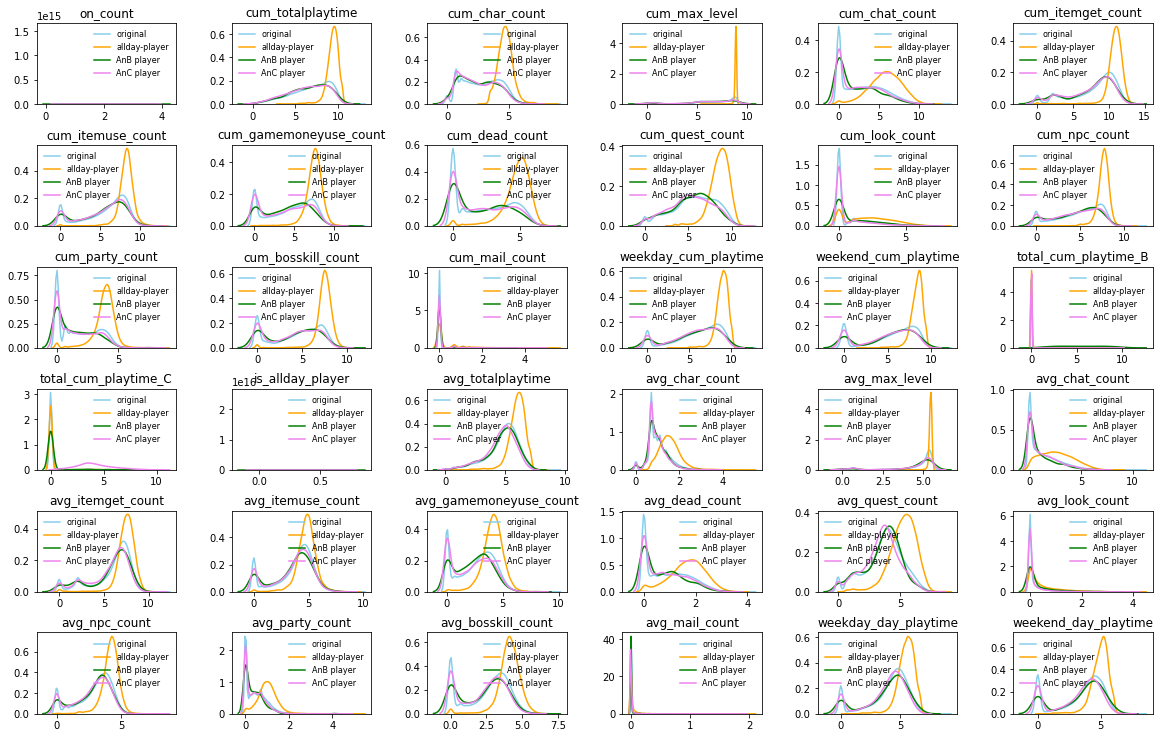

In [209]:
from scipy.stats import norm
import seaborn as sns
data = A.copy()

for col in data.columns:
    data[col] = np.log1p(data[col])
    
i = 1
plt.figure(figsize=(20, 12))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)

for col in data.columns:
    plt.subplot(6,6,i)
    sns.distplot(np.array(data[col]), hist=False, color='skyblue', label='original')
    ax1 = sns.distplot(np.array(data[data['is_allday_player'] > 0.0][col]), kde=True, hist=False, color='orange', label='allday-player')
    ax2 = sns.distplot(np.array(data[data['total_cum_playtime_B'] > .0][col]), color='green', kde=True, hist=False, label='AnB player')
    ax3 = sns.distplot(np.array(data[data['total_cum_playtime_C'] > .0][col]), color='violet', kde=True, hist=False, label='AnC player')
    plt.legend(fontsize='8', frameon=False)
    plt.title(str(col))
    i += 1

plt.suptitle("Aggregated scaled data feature distribution", fontsize= 16)
plt.show()

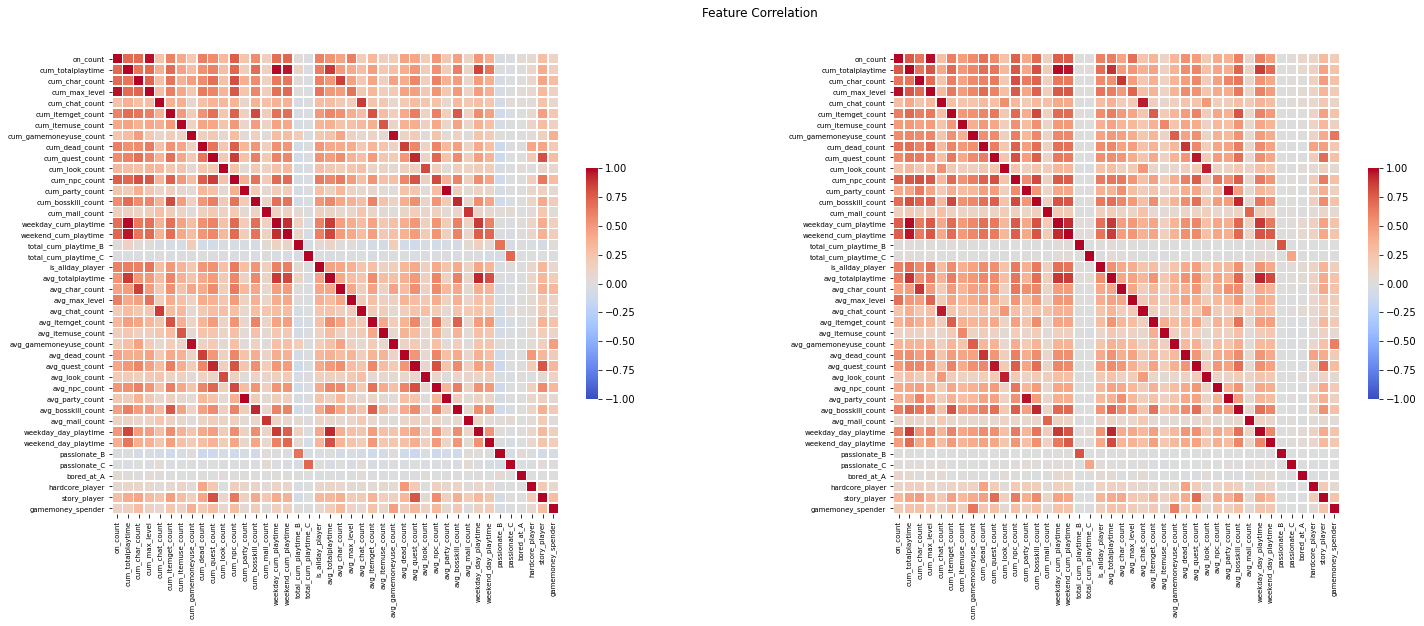

In [210]:
import seaborn as sns

plt.figure(figsize=(24, 8))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(1,2,1)
mask = np.triu(np.ones_like(A.loc[user_AnB,:].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnB,:].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.subplot(1,2,2)
mask = np.triu(np.ones_like(A.loc[user_AnC,:].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnC,:].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.suptitle("Feature Correlation")
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [211]:
A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113408 entries, 44583c63d496b1f975be42b73561252f7a7463e9f951328e1e93c7a4e0d03145 to 4b55b38a840c796c797b72ea9ada0ee95189562536c859aebe7a7d2b040ca742
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   on_count                113408 non-null  float64
 1   cum_totalplaytime       113408 non-null  float64
 2   cum_char_count          113408 non-null  float64
 3   cum_max_level           113408 non-null  float64
 4   cum_chat_count          113408 non-null  float64
 5   cum_itemget_count       113408 non-null  float64
 6   cum_itemuse_count       113408 non-null  float64
 7   cum_gamemoneyuse_count  113408 non-null  float64
 8   cum_dead_count          113408 non-null  float64
 9   cum_quest_count         113408 non-null  float64
 10  cum_look_count          113408 non-null  float64
 11  cum_npc_count           113408 non-null  float64
 12  cum_party_co

# Step 1. Predict label of 'Passionate player' : Classification

In [276]:
for y_col in ['passionate_B', 'passionate_C']:
    
    if y_col == 'passionate_B':
        train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1)
        test = A.drop(['total_cum_playtime_B'], axis=1)
        test = test.drop(user_AnB, axis=0)

    if y_col == 'passionate_C':
        train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1)
        test = A.drop(['total_cum_playtime_C'], axis=1)
        test = test.drop(user_AnC, axis=0)
        
    sc = StandardScaler()

    train_y = train[y_col]
    train_x = train.drop([y_col], axis=1)
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1)
    test_x = sc.fit_transform(test_x)
    
    print(Counter(train_y))
    
    ## Oversampling for Class-imbalanced Problem
    from imblearn.over_sampling import SMOTE 
    sm = SMOTE(random_state=42, k_neighbors=7)
    
    train_x, train_y = sm.fit_resample(train_x, train_y)
    print("Oversampled:", Counter(train_y))
    
    rf = RandomForestClassifier()
    rf.fit(train_x, train_y)
    pred_y = rf.predict(test_x)
    
    A.loc[test.index,y_col] = pred_y

Counter({0.0: 690, 1.0: 231})
Oversampled: Counter({0.0: 690, 1.0: 690})
Counter({0.0: 6714, 1.0: 2243})
Oversampled: Counter({0.0: 6714, 1.0: 6714})


In [277]:
print(Counter(A['passionate_B']))
print(Counter(A['passionate_C']))

Counter({0.0: 94582, 1.0: 18826})
Counter({0.0: 80067, 1.0: 33341})


## Model Candidates

## Step 1-1. Classification

In [214]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from xgboost import plot_importance
from xgboost import XGBClassifier

rf = RandomForestClassifier()
ab = AdaBoostClassifier(n_estimators=100)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=0)
dt = DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=0)
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
xgb = XGBClassifier(n_estimators=100, learning_rate = 0.01, max_depth = 1)

clf_models = [rf, ab, gb, dt, svm, xgb]
clf_names = ['Random Forest', 'Adaboost', 'Gradient Boosting', 'Decision Tree', 'SVM', 'xgboost']

K = 5
for model, name in zip(clf_models, clf_names):
    acc = cross_val_score(model, train_x, train_y, scoring='accuracy', cv=K)
    f1 = cross_val_score(model, train_x, train_y, scoring='f1', cv=K)
    print("Accuracy: \t\t %0.4f (+/- %0.4f) [%s]" % (acc.mean(), acc.std(), name))
    print("F1-score: \t\t %0.4f (+/- %0.4f)\n" % (f1.mean(), f1.std()))

Accuracy: 		 0.8251 (+/- 0.0767) [Random Forest]
F1-score: 		 0.8108 (+/- 0.1027)

Accuracy: 		 0.6591 (+/- 0.0705) [Adaboost]
F1-score: 		 0.6531 (+/- 0.1122)

Accuracy: 		 0.5479 (+/- 0.0071) [Gradient Boosting]
F1-score: 		 0.6856 (+/- 0.0041)

Accuracy: 		 0.6019 (+/- 0.0280) [Decision Tree]
F1-score: 		 0.6494 (+/- 0.0391)

Accuracy: 		 0.6088 (+/- 0.0153) [SVM]
F1-score: 		 0.6816 (+/- 0.0157)

Accuracy: 		 0.5479 (+/- 0.0071) [xgboost]
F1-score: 		 0.6856 (+/- 0.0041)



# Step 2. Predict probability of 'Passionate player' : regression

## Step 2-1. Regression

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping


for y_col in ['passionate_B', 'passionate_C']:

    # extract train data: user_AnB or user_AnC data
    if y_col == 'passionate_B':
        train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1)
        test = A.drop(['total_cum_playtime_B'], axis=1)
        test = test.drop(user_AnB, axis=0)

    if y_col == 'passionate_C':
        train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1)
        test = A.drop(['total_cum_playtime_C'], axis=1)
        test = test.drop(user_AnC, axis=0)

    sc = StandardScaler()

    train_y = train[y_col]
    train_x = train.drop([y_col], axis=1)
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1)
    test_x = sc.fit_transform(test_x)

    print(Counter(train_y))

    ## Oversampling for Class-imbalanced Problem
    from imblearn.over_sampling import SMOTE 
    sm = SMOTE(random_state=42, k_neighbors=7)
    train_x, train_y = sm.fit_resample(train_x, train_y)
    print("Oversampled:", Counter(train_y))

    ## Model training with oversampled dataset
    N = train_x.shape[0]
    M = train_x.shape[1]
    train_x = train_x.reshape(N, M, 1).copy()
    
    if y_col == 'passionate_B':
        model = Sequential()
        model.add(Conv1D(128, 8, input_shape=(M, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(1))

        optimizer = SGD(0.01)
        model.compile(optimizer=optimizer, loss='mse')
        
        early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        history = model.fit(x=np.array(train_x),
                          y=np.array(train_y),
                          validation_split = 0.3,
                          batch_size=128,
                          epochs=1000,
                          callbacks=[early_stop])
        
        losses = pd.DataFrame(history.history)
        losses.plot()
        
    if y_col == 'passionate_C':



    losses = pd.DataFrame(history.history)
    losses.plot()
    
    dnn = model
    
    ## Fit and Predict Probability with original dataset
    train_y = train[y_col]
    train_x = train.drop([y_col], axis=1)
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1)
    test_x = sc.fit_transform(test_x)

    N = train_x.shape[0]
    M = train_x.shape[1]
    train_x = train_x.reshape(N, M, 1).copy()

    N = test_x.shape[0]
    M = test_x.shape[1]
    test_x = test_x.reshape(N, M, 1).copy()

    prob_train = dnn.predict(train_x)
    prob_test = dnn.predict(test_x)
    
    ## Scale the prediction between 0 and 1
    msc = MinMaxScaler()
    prob_train = msc.fit_transform(prob_train)
    prob_test = msc.fit_transform(prob_test)
    
    feat_name = str("prob_"+y_col)
    A.loc[test.index, feat_name] = prob_test.reshape(len(test_x),)
    A.loc[train.index, feat_name] = prob_train.reshape(len(train_x),)
    A.loc[A[A[y_col] == 1.0].index, feat_name] = 1.0

In [287]:
#for y_col in ['passionate_B', 'passionate_C']:
y_col = 'passionate_C'

# extract train data: user_AnB or user_AnC data
if y_col == 'passionate_B':
    train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1)
    test = A.drop(['total_cum_playtime_B'], axis=1)
    test = test.drop(user_AnB, axis=0)

if y_col == 'passionate_C':
    train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1)
    test = A.drop(['total_cum_playtime_C'], axis=1)
    test = test.drop(user_AnC, axis=0)

sc = StandardScaler()

train_y = train[y_col]
train_x = train.drop([y_col], axis=1)
train_x = sc.fit_transform(train_x)

test_x = test.drop([y_col], axis=1)
test_x = sc.fit_transform(test_x)

print(Counter(train_y))

## Oversampling for Class-imbalanced Problem
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42, k_neighbors=7)
train_x, train_y = sm.fit_resample(train_x, train_y)
print("Oversampled:", Counter(train_y))

N = train_x.shape[0]
M = train_x.shape[1]
train_x = train_x.reshape(N, M, 1).copy()

N = test_x.shape[0]
M = test_x.shape[1]
test_x = test_x.reshape(N, M, 1).copy()

Counter({0.0: 6714, 1.0: 2243})
Oversampled: Counter({0.0: 6714, 1.0: 6714})


In [290]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

#model = Sequential()
#model.add(Dense(256,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(16,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1))

#model = Sequential()
#model.add(Conv1D(128, 8, input_shape=(train_x.shape[1], 1)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Conv1D(256, 5))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Conv1D(128 ,3))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(GlobalAveragePooling1D())
#model.add(Flatten())                 
#model.add(Dense(1))

model = Sequential()
model.add(Conv1D(128, 8, input_shape=(M, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1))

#optimizer = SGD(0.01)
optimizer = Adam(.01)
model.compile(optimizer=optimizer, loss='mse')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=np.array(train_x),
                  y=np.array(train_y),
                  validation_split = 0.3,
                  batch_size=128,
                  epochs=1000,
                  callbacks=[early_stop])

losses = pd.DataFrame(history.history)
losses.plot()

dnn = model

Train on 6269 samples, validate on 2688 samples
Epoch 1/1000
6269/6269 [==============================] - 14s 2ms/sample - loss: 446.7444 - val_loss: 0.3209
Epoch 2/1000
6269/6269 [==============================] - 13s 2ms/sample - loss: 0.2111 - val_loss: 0.1995
Epoch 3/1000
6269/6269 [==============================] - 13s 2ms/sample - loss: 0.1921 - val_loss: 0.1890
Epoch 4/1000
6269/6269 [==============================] - 12s 2ms/sample - loss: 0.1840 - val_loss: 0.1852
Epoch 5/1000
6269/6269 [==============================] - 12s 2ms/sample - loss: 0.1813 - val_loss: 0.1872
Epoch 6/1000
6269/6269 [==============================] - 12s 2ms/sample - loss: 0.1818 - val_loss: 0.1819
Epoch 7/1000
6269/6269 [==============================] - 13s 2ms/sample - loss: 0.1815 - val_loss: 0.1839
Epoch 8/1000
6269/6269 [==============================] - 14s 2ms/sample - loss: 0.1776 - val_loss: 0.1844
Epoch 9/1000
6269/6269 [==============================] - 12s 2ms/sample - loss: 0.1767 - val_

KeyboardInterrupt: 

In [289]:
train_y = train[y_col]
train_x = train.drop([y_col], axis=1)
train_x = sc.fit_transform(train_x)

test_x = test.drop([y_col], axis=1)
test_x = sc.fit_transform(test_x)

N = train_x.shape[0]
M = train_x.shape[1]
train_x = train_x.reshape(N, M, 1).copy()

N = test_x.shape[0]
M = test_x.shape[1]
test_x = test_x.reshape(N, M, 1).copy()

prob_train = dnn.predict(train_x)
prob_test = dnn.predict(test_x)

msc = MinMaxScaler()
prob_train = msc.fit_transform(prob_train)
prob_test = msc.fit_transform(prob_test)

print(prob_train[:10].reshape(10,).round(2))
print(np.array(train_y[:10]).round(2))
print("------------------------------")
print(prob_train[-10:].reshape(10,).round(2))
print(np.array(train_y[-10:]).round(2))

[0.89 0.92 0.91 0.92 0.9  0.88 0.77 0.91 0.89 0.78]
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
------------------------------
[0.91 0.87 0.87 0.91 0.78 0.93 0.9  0.93 0.88 0.89]
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]


In [286]:
feat_name = str("prob_"+y_col)
A.loc[test.index, feat_name] = prob_test.reshape(len(test_x),)
A.loc[train.index, feat_name] = prob_train.reshape(len(train_x),)
A.loc[A[A[y_col] == 1.0].index, feat_name] = 1.0

In [273]:
A

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,avg_mail_count,weekday_day_playtime,weekend_day_playtime,passionate_B,passionate_C,bored_at_A,hardcore_player,story_player,gamemoney_spender,prob_passionate_B
44583c63d496b1f975be42b73561252f7a7463e9f951328e1e93c7a4e0d03145,1.0,69.0,2.0,196.0,0.0,659.0,110.0,2.0,1.0,25.0,...,0.0,69.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.293335
d31dbe28ed7bae8abf030e279a18051e5ff853ffb4622088760c485775176707,6.0,105.0,5.0,50.0,61.0,22.0,51.0,2.0,0.0,15.0,...,0.0,9.833333,7.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.100257
568bfc11b9f891bcf9dbdef7e4f6a93f2caf6686461f2cdf51148d9669a1a041,29.0,10716.0,77.0,6002.0,42.0,21565.0,1185.0,1663.0,168.0,2538.0,...,0.0,234.448276,135.068966,0.0,1.0,0.0,0.0,0.0,0.0,0.000787
73169c98b3ebd1ac5ab9ce125b18dac75facc0a13152b4d1538425a474c05ee0,1.0,34.0,1.0,10.0,0.0,6.0,1.0,0.0,0.0,7.0,...,0.0,34.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.525860
2c7505602d3ff04fb4dbf2d7a03563c1a2c14f9e50057f1ff30f166c1457ea20,18.0,2731.0,26.0,1930.0,86.0,38897.0,1724.0,526.0,22.0,1355.0,...,0.0,138.000000,13.722222,1.0,0.0,0.0,0.0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a3b0dad9ee125aa765aec8a71e1eebe4f543f870f976dedefcfeb1717b06ab2a,9.0,1087.0,12.0,581.0,8.0,7853.0,792.0,19.0,5.0,329.0,...,0.0,90.000000,30.777778,1.0,0.0,0.0,0.0,0.0,0.0,1.000000
3df29a277432285626088f21dca738543ef94e22c11e5a5d3a06a4e48223a3b7,2.0,33.0,2.0,206.0,0.0,144.0,18.0,0.0,0.0,6.0,...,0.0,0.000000,16.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.460009
5c6f788e4969ab7648208b2e3157bf38e974d65bb62d45fc57e5e912e1f7d69e,31.0,31998.0,219.0,7365.0,53.0,119478.0,3981.0,2871.0,205.0,10759.0,...,0.0,641.225806,390.967742,0.0,0.0,0.0,0.0,1.0,0.0,0.066547
beb31dab9ab2eceddb2677aaffa9812ac417b89f0412f87c11da7a149f7613d7,18.0,1895.0,18.0,1897.0,0.0,21822.0,1253.0,197.0,5.0,681.0,...,0.0,60.611111,44.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.333306


In [173]:
prob_y[-10:].reshape(10,).round(2)

array([0.3 , 0.31, 0.36, 0.15, 0.16, 0.32, 0.31, 0.29, 0.31, 0.26],
      dtype=float32)

In [167]:
np.array(A.loc[test.index,:][-10:][y_col])

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

In [168]:
prob_y[-10:].reshape(10,).round(2)

array([ 0.06,  0.22,  0.31, -0.01, -0.  ,  0.22,  0.23, -0.06,  0.27,
        0.19], dtype=float32)

In [98]:
np.array(train_y[:10])

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [99]:
prob_y[:10].reshape(10,).round(2)

array([0.52, 0.04, 0.03, 0.06, 0.07, 0.07, 0.54, 0.04, 0.06, 0.07],
      dtype=float32)

In [1]:
A[y_col] - prob_y.reshape(len(test),)

NameError: name 'A' is not defined

In [ ]:
feat_name = str("prob_"+y_col)
A.loc[test.index, feat_name] = prob_y.reshape(len(test),)

if y_col == 'passionate_C':
    A.loc[user_AnC, feat_name] = A.loc[user_AnC, y_col]
if y_col == 'passionate_B':
    A.loc[user_AnB, feat_name] = A.loc[user_AnB, y_col]

In [298]:
A[A['passionate_C'] == 1]

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,avg_maxlevel,avg_quest,bored_at_A,avg_dead,hardcore_player,avg_npc,story_player,avg_gamemoneyuse,gamemoney_spender,prob_passionate_C
3357233ff933db12de31d5a7c8857cbb7710bafbb11297050157619549ac0bf0,4.0,318.0,6.0,452.0,0.0,2419.0,317.0,32.0,1.0,47.0,...,113.000000,11.750000,0.0,0.250000,0.0,18.500000,0.0,8.000000,0.0,1.000000
b8e8207344e3f5df7727252baf416238da06cc150fb37831459c47fdca857b85,8.0,1023.0,9.0,1028.0,121.0,5354.0,631.0,134.0,12.0,722.0,...,128.500000,90.250000,0.0,1.500000,0.0,24.375000,0.0,16.750000,0.0,1.000000
93aacae84e408fbb2a4be6870f789e59b852de99bf242fea94c35f779d345614,7.0,655.0,11.0,1439.0,15.0,3191.0,276.0,188.0,13.0,132.0,...,205.571429,18.857143,0.0,1.857143,0.0,19.285714,0.0,26.857143,0.0,1.000000
bd3c73b57b75c9bd1c9e469c8d308d55fc7e8ec2caaf3fdc4000df30f8d61e62,6.0,718.0,7.0,814.0,1.0,5367.0,1566.0,16.0,11.0,170.0,...,135.666667,28.333333,0.0,1.833333,0.0,9.833333,0.0,2.666667,0.0,0.415025
d0e055d44ea0ce4e590f0f5c5ec1b3c0e6174833e246e5aa91d095a2823bb727,8.0,743.0,8.0,594.0,12.0,2306.0,409.0,9.0,10.0,204.0,...,74.250000,25.500000,0.0,1.250000,0.0,9.375000,0.0,1.125000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c1fb8a8c853bff8b5ac060f135fc0376ebc3cf4b1bedc3ed38bd07080a6b2a,24.0,2320.0,54.0,4998.0,92.0,12715.0,1004.0,769.0,70.0,1616.0,...,208.250000,67.333333,0.0,2.916667,0.0,47.541667,0.0,32.041667,0.0,1.000000
664ce897ea206331fb48b1dff5a4e34593ea4eab294efbbe4d220c42f9204a00,31.0,4520.0,40.0,6759.0,109.0,19912.0,1203.0,1095.0,117.0,456.0,...,218.032258,14.709677,0.0,3.774194,0.0,29.290323,0.0,35.322581,0.0,0.054133
d861a1aa31f4a25803281407f0304d6294eab75c5d4aeeb40971e24978f0d0d6,4.0,687.0,4.0,493.0,0.0,3119.0,192.0,15.0,8.0,158.0,...,123.250000,39.500000,0.0,2.000000,0.0,21.750000,0.0,3.750000,0.0,0.061510
84408d18434de454f3d34109af01b003c0bd2a65a8306785ff8f27a5d51895f5,4.0,616.0,3.0,99.0,0.0,1104.0,101.0,3.0,9.0,124.0,...,24.750000,31.000000,0.0,2.250000,0.0,8.750000,0.0,0.750000,0.0,0.191057


In [299]:
A.loc[user_AnC, y_col]

2a67b841db6cf75e15d6a359cc9fd0f9cafe158019669d4355a20b9e5ba58a65    0.0
1b5e04571f5597933ce167b2524e0887175aa898ea504b7d69c0d0ac6c0edca2    0.0
92dcab4ec69ba26ef635cda9662f3f427f8ea38870f850136be444076a7ccccd    0.0
8be4791d797d4278600de6e370420a4ee8f0d97dca9b56aadd80f3e5a2a85c71    0.0
b096732c9741fb4e272d3a314f8efeae060ae9edf9e9b7fd825f85de3d11ee91    0.0
                                                                   ... 
c1c2f93cab5c32a5f4b83a7b16c2a4029ad8afb0916604fdb2a60cd93d30b1b0    0.0
4ac613abfb71a1dc8a5a93028ff1e533d23d305e0bc2c1ebbc4d095af11a1b86    0.0
464ffffe4b7a27be1b09c5a0221b2e348c38e3ef3bd1166c8110cca643d38e73    0.0
08b74acdd5653e4f2b273b5d1dd21e92293cc3596c0897f0930e73e6e34dbb04    0.0
bd84d8192243e18214658a26f32500ba1d45c972277b671dfeddf50c2ac66cb0    0.0
Name: passionate_C, Length: 8957, dtype: float64

In [ ]:
from sklearn import linear_model as lin
from sklearn.model_selection import cross_val_score

linReg = lin.LinearRegression()
ridge = lin.Ridge(alpha=.5)
lasso = lin.Lasso(alpha=0.1)
cv_Ridge = lin.RidgeCV(alphas=np.logspace(-6, 6, 13))
cv_Lasso = lin.LassoCV()
ard = lin.ARDRegression(compute_score=True)

from sklearn.ensemble import RandomForestRegressor
rfReg = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)
reg_models = [cv_Lasso, rfReg, ard]
reg_names = ['Lasso_CV', 
             'Random Forest Regression', 
             'ARD']
K = 5
for model, name in zip(reg_models, reg_names):
    r2 = cross_val_score(model, train_x, train_y, scoring='r2', cv=K)
    MSE = cross_val_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=K)
    RMSE = cross_val_score(model, train_x, train_y, scoring='neg_root_mean_squared_error', cv=K)
    
    print("R-square: \t\t %0.4f (+/- %0.4f) [%s]" % (r2.mean(), r2.std(), name))
    print("MSE: \t\t\t %0.4f (+/- %0.4f)" % (MSE.mean(), MSE.std()))
    print("RMSE: \t\t\t %0.4f (+/- %0.4f)\n" % (RMSE.mean(), RMSE.std()))